In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

In [18]:
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [19]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [20]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [21]:
Base.classes.keys()

['measurement', 'station']

In [22]:
Measurement = Base.classes.measurement
Station = Base.classes.station

In [24]:
session = Session(engine)
inspector = inspect(engine)

In [32]:
measurement_columns = inspector.get_columns('measurement')

for column in measurement_columns:
    print(column['name'])

id
station
date
prcp
tobs


In [33]:
station_columns = inspector.get_columns('station')

for column in station_columns:
    print(column['name'])

id
station
name
latitude
longitude
elevation


In [39]:
earliest_date = session.query(Measurement.date).order_by(Measurement.date).first()
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

print(f'Earliest Date {earliest_date[0]}')
print(f'Last Date {last_date[0]}')

Earliest Date 2010-01-01
Last Date 2017-08-23


In [43]:
last_date = dt.datetime.strptime(last_date[0], '%Y-%m-%d')

In [44]:
querydate = dt.date(last_date.year -1, last_date.month, last_date.day)
querydate

datetime.date(2016, 8, 23)

In [49]:
sel = [Measurement.date, Measurement.prcp]
query_results = session.query(*sel).filter(Measurement.date >= querydate).all()

In [62]:
prcp_df = pd.DataFrame(query_results, columns = ['Date', 'Prcp']).set_index('Date')
prcp_df = prcp_df.dropna(how = 'any')
prcp_df = prcp_df.sort_values(by = 'Date', axis=0, ascending=True)
prcp_df.head()

,Prcp
Date,
2016-08-23,0.00
2016-08-23,0.02
2016-08-23,0.05
2016-08-23,0.70
2016-08-23,0.15


In [66]:
dates = prcp_df.index.tolist()
prcp = prcp_df['Prcp'].tolist()

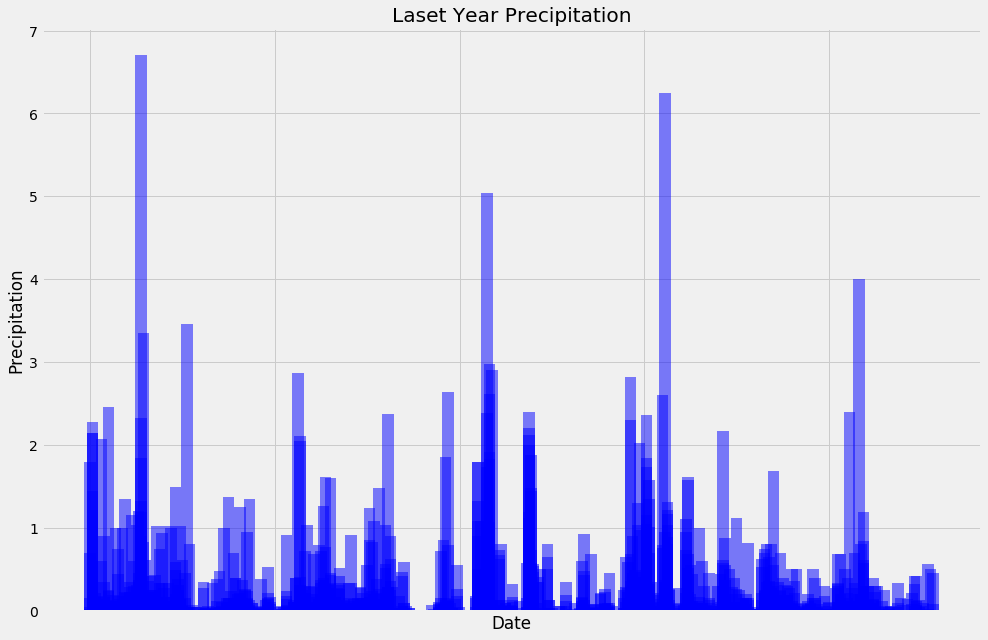

In [81]:
plt.figure(figsize=(15,10))
plt.bar(dates,prcp,width = 5 ,color='b', alpha=0.5, align="center",label='Precipitation')

plt.tick_params(axis='x', which='both', bottom=False, top=False,labelbottom=False) 
major_ticks = np.arange(0,400,80)
plt.xticks(major_ticks)

plt.xlabel('Date')
plt.ylabel('Precipitation')
plt.title(f'Laset Year Precipitation')
plt.show()


In [78]:
prcp_df.describe()

,Prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [84]:
station_count = session.query(Station.id).count()
print(f'Number of stations: {station_count}')

Number of stations: 9


In [88]:
sel = [Measurement.station,func.count(Measurement.id)]

stations = session.query(*sel).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).all()
    
stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [93]:
print(f'Station {stations[0][0]} is most active')

Station USC00519281 is most active


In [138]:
tmps = session.query(Measurement.tobs).\
    filter(Measurement.station == stations[0][0]).\
    filter(Measurement.date >= querydate).all()

# convert query result to list using list comprehension
tmps = [item for tmp in tmps for item in tmp]

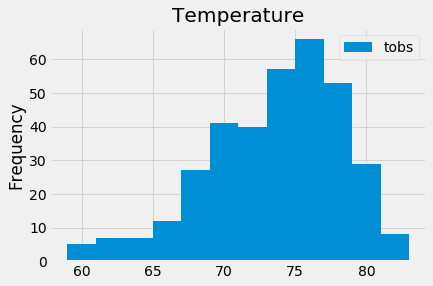

In [140]:
plt.hist(tmps, bins=12,rwidth=1.0,label='tobs')
plt.grid(axis='both', alpha=0.75)
plt.ylabel('Frequency')
plt.title(f"Temperature")
plt.legend()
plt.show()